In [37]:
import tensorflow as tf
import tensorflow_text as tf_text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
def load_data(path):
	with open('fra.txt','r') as f:
		lines = f.read().split('\n')[:-1]

	pairs = [line.split('\t') for line in lines]

	context = np.array([context for target, context in pairs])
	target = np.array([target for target, context in pairs])

	return target, context

In [39]:
target_raw, context_raw = load_data('fra.txt')

In [40]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
	tf.data.Dataset
	.from_tensor_slices((context_raw[is_train], target_raw[is_train]))
	.shuffle(BUFFER_SIZE)
	.batch(BATCH_SIZE))
val_raw = (
	tf.data.Dataset
	.from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
	.shuffle(BUFFER_SIZE)
	.batch(BATCH_SIZE))

In [41]:
for example_context_strings, example_target_strings in train_raw.take(1):
	print(example_context_strings[:5])
	print()
	print(example_target_strings[:5])
	print(example_context_strings.shape)
	break

tf.Tensor(
[b'Les gar\xc3\xa7ons ont \xc3\xa9t\xc3\xa9 bless\xc3\xa9s.'
 b'Ce qui est en question dans ce d\xc3\xa9bat est la survie de notre plan\xc3\xa8te.'
 b"J'ai besoin de savoir tout ce que vous connaissez \xc3\xa0 propos de Tom."
 b"Je n'ai pas fait de b\xc3\xa9n\xc3\xa9volat."
 b"Vous avez l'air un peu jeune pour \xc3\xaatre enseignante."], shape=(5,), dtype=string)

tf.Tensor(
[b'The boys were injured.'
 b'What is at issue in this debate is the survival of our planet.'
 b'I need to know everything that you know about Tom.'
 b"I didn't volunteer." b'You look a little young to be a teacher.'], shape=(5,), dtype=string)
(64,)


In [42]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [43]:
def tf_lower_and_split_punct(text):
	# Split accented characters.
	text = tf_text.normalize_utf8(text, 'NFKD')
	text = tf.strings.lower(text)
	# Keep space, a to z, and select punctuation.
	text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
	# Add spaces around punctuation.
	text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
	# Strip whitespace.
	text = tf.strings.strip(text)

	text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
	return text

In [44]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [45]:
max_vocab_size = 10000

context_text_processor = tf.keras.layers.TextVectorization(
	standardize=tf_lower_and_split_punct,
	max_tokens=max_vocab_size,
	ragged=True)

context_text_processor.adapt(train_raw.map(lambda context, target: context))

In [46]:
target_text_processor = tf.keras.layers.TextVectorization(
	standardize=tf_lower_and_split_punct,
	max_tokens=max_vocab_size,
	ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'i', 'you', 'to', 'the', '?']

In [47]:
example_tokens = context_text_processor(example_context_strings)
print(example_tokens[0])
print(example_context_strings[0])
print(example_tokens[2])
print(example_context_strings[2])

tf.Tensor([   2   24  942  102   67 1995    4    3], shape=(8,), dtype=int64)
tf.Tensor(b'Les gar\xc3\xa7ons ont \xc3\xa9t\xc3\xa9 bless\xc3\xa9s.', shape=(), dtype=string)
tf.Tensor(
[   2   26   88    6  194   40   20   10   14 2642    7  521    6   16
    4    3], shape=(16,), dtype=int64)
tf.Tensor(b"J'ai besoin de savoir tout ce que vous connaissez \xc3\xa0 propos de Tom.", shape=(), dtype=string)


In [48]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] les garcons ont ete blesses . [END]'

In [49]:
context_vocab.shape

(10000,)

Text(0.5, 1.0, 'Mask')

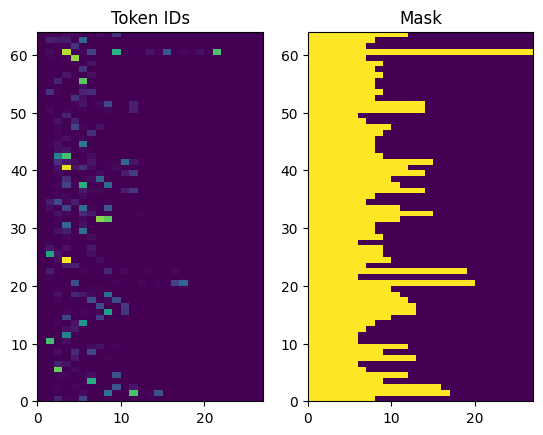

In [50]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [51]:
def process_text(context, target):
	context = context_text_processor(context).to_tensor()
	target = target_text_processor(target)
	targ_in = target[:,:-1].to_tensor()
	targ_out = target[:,1:].to_tensor()
	return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [52]:
for (ex_context_tok,ex_tar_in),ex_tar_out in train_ds.take(1):
	print(ex_context_tok[0,:].numpy())
	print(ex_context_tok.numpy().shape)
	print()
	print(ex_tar_in[0,:].numpy())
	print(ex_tar_in.numpy().shape)
	print(ex_tar_out[0,:].numpy())
	print(ex_tar_out.numpy().shape)

[   2   19  167   39   12  811    9   11  575  192  560   12  811    9
   11  575  192  313   36   13 1666    4    3]
(64, 23)

[   2   10  167   35  751  422   11   35  751 1052   19    8  230  314
    4    0]
(64, 16)
[  10  167   35  751  422   11   35  751 1052   19    8  230  314    4
    3    0]
(64, 16)


In [53]:
units = 256

In [54]:
class Encoder(tf.keras.layers.Layer):
	def __init__(self, text_processor, units,**kwargs):
		super(Encoder,self).__init__()
		self.text_processor = text_processor
		self.vocab_size = text_processor.vocabulary_size()
		self.units = units

		self.embedding = tf.keras.layers.Embedding(self.vocab_size,units,mask_zero=True)

		self.rnn = tf.keras.layers.Bidirectional(
			merge_mode='sum',
			layer=tf.keras.layers.GRU(units,
									  return_sequences=True,
									  recurrent_initializer='glorot_uniform')
		)
	
	def call(self, x):
		x = self.embedding(x)
		x = self.rnn(x)
		return x

	def convert_input(self,texts):
		texts = tf.convert_to_tensor(texts)
		if(len(texts))==0:
			texts = tf.convert_to_tensor(texts)[tf.newaxis]
		context = self.text_processor(texts).to_tensor()
		context = self(context)
		return context

In [55]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, units)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 23)
Encoder output, shape (batch, s, units): (64, 23, 256)


In [56]:
class CrossAttention(tf.keras.layers.Layer):
	def __init__(self, units,**kwargs):
		super().__init__()
		self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units,num_heads=1,**kwargs)
		self.layernorm = tf.keras.layers.LayerNormalization()
		self.add = tf.keras.layers.Add()

	def call(self,x,context):
		attn_output,attn_scores = self.mha(
			query = x,
			value = context,
			return_attention_scores = True
		)
		attn_scores = tf.reduce_mean(attn_scores,axis=1) 
		self.last_attention_weights = attn_scores

		x = self.add([x,attn_output])
		x = self.layernorm(x)
		return x

In [57]:
attention_layer = CrossAttention(units)
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),output_dim=units,mask_zero=True)
ex_tar_emb = embed(ex_tar_in)

result = attention_layer(ex_tar_emb,ex_context)

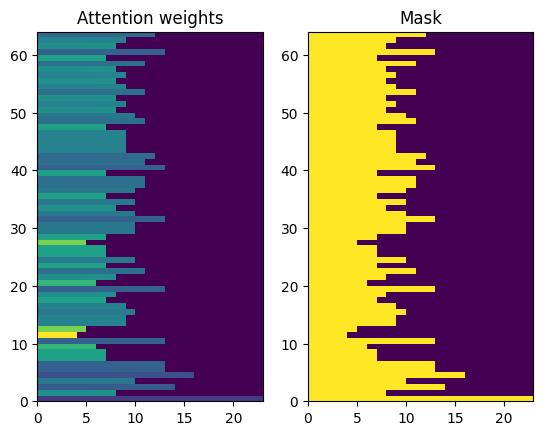

In [58]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [59]:
class Decoder(tf.keras.layers.Layer):  
		def __init__(self, text_processor,units):
				super().__init__()
				self.text_processor = text_processor
				self.units = units

				self.vocab_size = text_processor.vocabulary_size()

				self.word_to_id = tf.keras.layers.StringLookup(
				vocabulary=text_processor.get_vocabulary(),
				mask_token='', oov_token='[UNK]')
				self.id_to_word = tf.keras.layers.StringLookup(
						vocabulary=text_processor.get_vocabulary(),
						mask_token='', oov_token='[UNK]',
						invert=True)
				self.start_token = self.word_to_id('[START]')
				self.end_token = self.word_to_id('[END]')

				self.embedding = tf.keras.layers.Embedding(self.vocab_size,
																							 units, mask_zero=True)

				# 2. The RNN keeps track of what's been generated so far.
				self.rnn = tf.keras.layers.GRU(units,
																		return_sequences=True,
																		return_state=True,
																		recurrent_initializer='glorot_uniform')

				# 3. The RNN output will be the query for the attention layer.
				self.attention = CrossAttention(units)

				# 4. This fully connected layer produces the logits for each
				# output token.
				self.output_layer = tf.keras.layers.Dense(self.vocab_size)

				
		def call(self,context,x,state=None,return_state = False):
				x = self.embedding(x)
				x,state = self.rnn(x,initial_state = state)

				x = self.attention(x,context)

				self.last_attention_weights = self.attention.last_attention_weights

				logits = self.output_layer(x)

				if return_state:
						return logits,state
				
				else:   
						return logits
				
		def get_initial_state(self, context):
			batch_size = tf.shape(context)[0]
			start_tokens = tf.fill([batch_size, 1], self.start_token)
			done = tf.zeros([batch_size, 1], dtype=tf.bool)
			embedded = self.embedding(start_tokens)
			return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

		def tokens_to_text(self, tokens):
			words = self.id_to_word(tokens)
			result = tf.strings.reduce_join(words, axis=-1, separator=' ')
			result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
			result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
			return result

		def get_next_token(self, context, next_token, done, state, temperature = 0.0):
			logits, state = self(
				context, next_token,
				state = state,
				return_state=True) 

			if temperature == 0.0:
				next_token = tf.argmax(logits, axis=-1)
			else:
				logits = logits[:, -1, :]/temperature
				next_token = tf.random.categorical(logits, num_samples=1)

			# If a sequence produces an `end_token`, set it `done`
			done = done | (next_token == self.end_token)
			# Once a sequence is done it only produces 0-padding.
			next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

			return next_token, done, state
				

In [60]:
decoder  = Decoder(target_text_processor,units)

logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 23, 256)
input target tokens shape: (batch, t) (64, 16)
logits shape shape: (batch, target_vocabulary_size) (64, 16, 10000)


In [61]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
	# Run one step.
	next_token, done, state = decoder.get_next_token(
			ex_context, next_token, done, state, temperature=1.0)
	# Add the token to the output.
	tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:5].numpy()

array([b'toothbrush feverish anybody legibly bangkok bellows wires selfies obviously verb',
       b'appreciate climate sustain morons contributions chapter dignity chopsticks speak army',
       b'six ignores detests dodge hungry horses him backyard uncanny agency',
       b'sample complacent wales slowly solo looking dumbfounded reserved agency rainforests',
       b'chapped stove hello argument observe fashions apprehended hills trainee irreplaceable'],
      dtype=object)

In [62]:
class Translator(tf.keras.Model):
		def __init__(self,units, context_text_processor,target_text_processor):
				super().__init__()

				encoder = Encoder(context_text_processor,units)
				decoder = Decoder(target_text_processor,units)

				self.encoder = encoder
				self.decoder = decoder


		def call(self,inputs):
			context,x = inputs
			context = self.encoder(context)
			logits = self.decoder(context,x)
			
			try:
					del logits._keras_mask
			except AttributeError:
					pass
			
			return logits
				
		def translate(self,
									texts, *,
									max_length=50,
									temperature=0.0):
			# Process the input texts
			context = self.encoder.convert_input(texts)
			batch_size = tf.shape(texts)[0]

			# Setup the loop inputs
			tokens = []
			attention_weights = []
			next_token, done, state = self.decoder.get_initial_state(context)

			for _ in range(max_length):
				# Generate the next token
				next_token, done, state = self.decoder.get_next_token(
						context, next_token, done,  state, temperature)

				# Collect the generated tokens
				tokens.append(next_token)
				attention_weights.append(self.decoder.last_attention_weights)

				if tf.executing_eagerly() and tf.reduce_all(done):
					break

			# Stack the lists of tokens and attention weights.
			tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
			self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

			result = self.decoder.tokens_to_text(tokens)
			return result

In [63]:
model =  Translator(units,context_text_processor,target_text_processor)

print("(ex_context_tok,ex_tar_in)")
logits = model((ex_context_tok,ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

(ex_context_tok,ex_tar_in)
Context tokens, shape: (batch, s, units) (64, 23)
Target tokens, shape: (batch, t) (64, 16)
logits, shape: (batch, t, target_vocabulary_size) (64, 16, 10000)


In [64]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [65]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [66]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 4s 24ms/step - loss: 9.2134 - masked_acc: 9.5785e-05 - masked_loss: 9.2134


{'loss': 9.213360786437988,
 'masked_acc': 9.578543540555984e-05,
 'masked_loss': 9.213360786437988}

In [67]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 10s 43ms/step - loss: 5.3323 - masked_acc: 0.2390 - masked_loss: 5.3323 - val_loss: 4.3494 - val_masked_acc: 0.3279 - val_masked_loss: 4.3494
Epoch 2/100
100/100 [==============================] - 4s 43ms/step - loss: 3.9149 - masked_acc: 0.3868 - masked_loss: 3.9149 - val_loss: 3.4882 - val_masked_acc: 0.4341 - val_masked_loss: 3.4882
Epoch 3/100
100/100 [==============================] - 4s 42ms/step - loss: 3.2999 - masked_acc: 0.4639 - masked_loss: 3.2999 - val_loss: 2.9514 - val_masked_acc: 0.5034 - val_masked_loss: 2.9514
Epoch 4/100
100/100 [==============================] - 4s 43ms/step - loss: 2.9013 - masked_acc: 0.5198 - masked_loss: 2.9013 - val_loss: 2.6960 - val_masked_acc: 0.5452 - val_masked_loss: 2.6960
Epoch 5/100
100/100 [==============================] - 4s 43ms/step - loss: 2.5520 - masked_acc: 0.5685 - masked_loss: 2.5520 - val_loss: 2.3471 - val_masked_acc: 0.5961 - val_masked_loss: 2.3471
Epoch 6/100
100/100

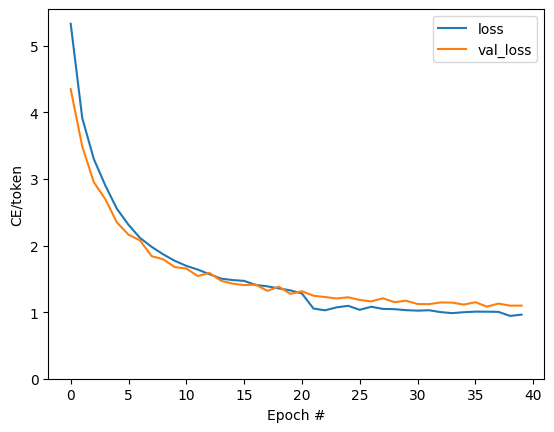

In [68]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

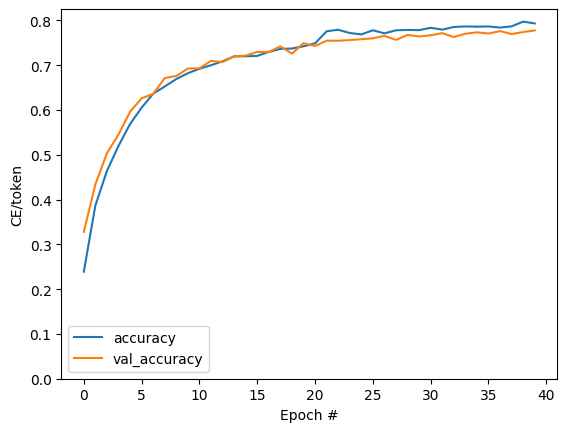

In [69]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [72]:
result = model.translate(['C’est un jour merveilleux']) # that is a wonderful day
print(result.numpy()[0].decode())

thats a wonderful day . 
